In [1]:
import sys
!{sys.executable} -m pip install PyAthena

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
from pyathena import connect
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
conn = connect(s3_staging_dir='s3://hyperflow-athena-results',
               region_name='us-east-1')

In [4]:
METRICS_COLS = ','.join(['time', 'workflowId', 'jobId', 'name', 'parameter', 'valueStr', 'valueFloat', 'valueInt', 'valueDict'])
SYS_INFO_COLS = ','.join(['cpu', 'mem', 'jobId'])
JOB_DESCRIPTION_COLS = ','.join(['workflowName', 'size', 'version', 'hyperflowId', 'jobId', 'env', 'nodeName', 'executable', 'args', 'inputs', 'outputs', 'name', 'command'])

In [5]:
def query_athena_metrics(table):
    metrics_df = pd.read_sql('SELECT {} FROM hyperflow_logs.{};'.format(METRICS_COLS, table), conn)
    return metrics_df[metrics_df['time'].notnull()]

def query_athena_sysinfo(table):
    metrics_df = pd.read_sql('SELECT {} FROM hyperflow_logs.{};'.format(SYS_INFO_COLS, table), conn)
    return metrics_df[metrics_df['cpu'].notnull()]

def merge_value_num(df):
    df['valueNum'] = [val[0] if math.isnan(val[1]) else val[1] for val in zip(df['valueFloat'], df['valueInt'])]

In [6]:
def get_resource_mean(metrics_df, resource):
    return metrics_df[(metrics_df['parameter']==resource) & (~metrics_df['valueNum'].isna()) & (metrics_df['valueNum'] > 0)].groupby('name')['valueNum'].mean()

def compare_resource_mean(metrics_df1, metrics_df2, resource):
    ctime3 = get_resource_mean(metrics_df1, resource).to_frame()
    ctime32 = get_resource_mean(metrics_df2, resource).to_frame()
    merged = pd.concat([ctime3, ctime32], keys=['3','32'], axis=1)
    #merged.plot(kind='bar')
    return merged

def print_sys_info(sys_info, component='cpu'):
    if component == 'cpu':
        cpu_string = sys_info.iloc[0]['cpu']
        print(cpu_string[cpu_string.find('cores'):cpu_string.find('socket')])
        #print('cpu speed:',sys_info.iloc[0]['cpu']['speed'])
        #print('cpu cores:',sys_info.iloc[0]['cpu']['cores'])
        #print('cpu physicalcores:',sys_info.iloc[0]['cpu']['physicalCores'])
        #print('cpu processors:',sys_info.iloc[0]['cpu']['processors'])

In [7]:
def draw_comparison_bar_plot(instances_dfs, resource, labels, log=False):
    fig, ax = plt.subplots()
    width = 0.8/len(instances_dfs)
    for i, (instance_df,label) in enumerate(zip(instances_dfs,labels)):
        res_mean = get_resource_mean(instance_df, resource)
        x = np.arange(len(res_mean))
        ax.bar(x - 0.4 + width/2 + width*i, res_mean, width, label=label, log=log)
        ax.set_xticks(x)
        ax.set_xticklabels(res_mean.index)
        
    
    ax.set_ylabel('Value')
    ax.set_title(resource+' values by project and instance')
    plt.xticks(rotation=90)
    
    ax.legend()

def print_speedup_ratio(instances_dfs, resource):
    res_mean1 = get_resource_mean(instances_dfs[0], resource)
    res_mean2 = get_resource_mean(instances_dfs[1], resource)
    ratios = 1-res_mean2/res_mean1
    for idx, ratio in zip(ratios.index, ratios):
        print(idx, str(int(100*ratio)) + '%')

In [18]:
# aws/t3.large/montage2__0_01__1_0_0__2020_06_01_18_14_25
# aws/t3.2xlarge/montage2__0.01__1.0.0__2020_06_20_19_36_56

# aws/t3.large/soykb__134__1_0_0__2020_06_21_01_30_50
# aws/t3.2xlarge/soykb__134__1_0_0__2020_05_28_05_30_50

metrics_df_large3 = query_athena_metrics('montage2__0_01__1_0_0__2020_06_01_18_14_25') # aws/t3.large/montage2__0_01__1_0_0__2020_06_01_18_14_25
merge_value_num(metrics_df_large3)
metrics_df_large32 = query_athena_metrics('montage2__0.01__1.0.0__2020_06_20_19_36_56') # aws/t3.large/montage2__0_01__1_0_0__2020_06_01_18_14_25
merge_value_num(metrics_df_large32)

In [13]:
sysinfo_df_large3 = query_athena_sysinfo('montage2__0_01__1_0_0__2020_06_01_18_14_25') # aws/t3.large/montage2__0_01__1_0_0__2020_06_01_18_14_25
sysinfo_df_large32 = query_athena_sysinfo('montage2__0_01__1_0_0__2020_06_20_19_36_56') # aws/t3.large/montage2__0_01__1_0_0__2020_06_01_18_14_25
print('CPU info t3.large: ', end = '')
print_sys_info(sysinfo_df_large3)
print('CPU info t3.2xlarge: ', end = '')
print_sys_info(sysinfo_df_large32)

CPU info t3.large: cores=2, physicalcores=2, processors=1, 
CPU info t3.2xlarge: cores=8, physicalcores=8, processors=1, 


mAdd 44%
mBackground 35%
mBgModel -79%
mConcatFit 20%
mDiffFit 46%
mImgtbl -12%
mProject 29%
mViewer 16%


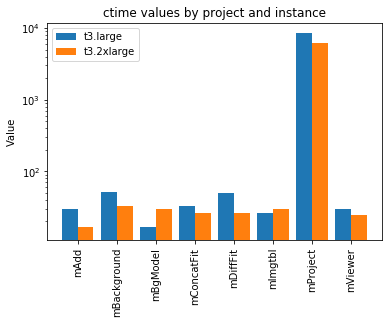

In [14]:
draw_comparison_bar_plot([metrics_df_large3, metrics_df_large32], 'ctime', ['t3.large', 't3.2xlarge'], log=True)
print_speedup_ratio([metrics_df_large3, metrics_df_large32], 'ctime')

mAdd -14%
mBackground 17%
mBgModel -109%
mConcatFit -25%
mDiffFit 0%
mImgtbl -53%
mProject 4%
mViewer 0%


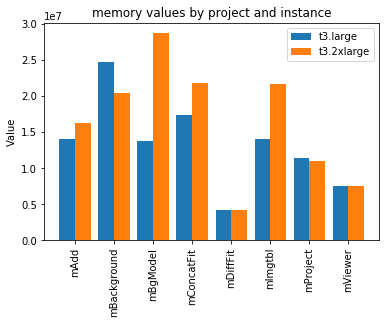

In [15]:
draw_comparison_bar_plot([metrics_df_large3, metrics_df_large32], 'memory', ['t3.large', 't3.2xlarge'])
print_speedup_ratio([metrics_df_large3, metrics_df_large32], 'memory')

mProject -4%


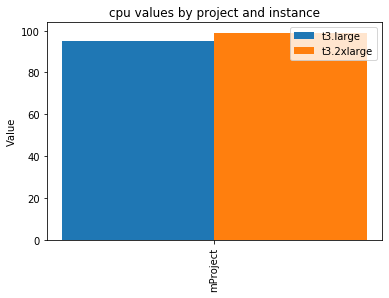

In [16]:
draw_comparison_bar_plot([metrics_df_large3, metrics_df_large32], 'cpu', ['t3.large', 't3.2xlarge'])
print_speedup_ratio([metrics_df_large3, metrics_df_large32], 'cpu')

In [23]:
# t3.large/2020_06_01_19_27_45
# t3.2xlarge/2020_06_20_19_45_49
# c2-standard-4/2020_06_01_08_39_05
# e2-standard-4/2020_06_01_18_26_43
# n1-standard-4/2020_06_21_18_22_10
# n2-standard-4/2020_06_21_18_21_41
# n2d-standard-4/2020_06_21_17_25_44

metrics_df_large3 = query_athena_metrics('montage2__0_25__1_0_0__2020_06_01_19_27_45')
merge_value_num(metrics_df_large3)
metrics_df_large32 = query_athena_metrics('montage2__0_25__1_0_0__2020_06_20_19_45_49')
merge_value_num(metrics_df_large32)
metrics_df_c2_standard = query_athena_metrics('montage2__0_25__1_0_0__2020_06_01_08_39_05')
merge_value_num(metrics_df_c2_standard)
metrics_df_e2_standard = query_athena_metrics('montage2__0_25__1_0_0__2020_06_01_18_26_43')
merge_value_num(metrics_df_e2_standard)
metrics_df_n1_standard = query_athena_metrics('montage2__0_25__1_0_0__2020_06_21_18_22_10')
merge_value_num(metrics_df_n1_standard)
metrics_df_n2d_standard = query_athena_metrics('montage2__0_25__1_0_0__2020_06_21_18_21_41')
merge_value_num(metrics_df_n2d_standard)
metrics_df_n2_standard = query_athena_metrics('montage2__0_25__1_0_0__2020_06_21_17_25_44')
merge_value_num(metrics_df_n2_standard)

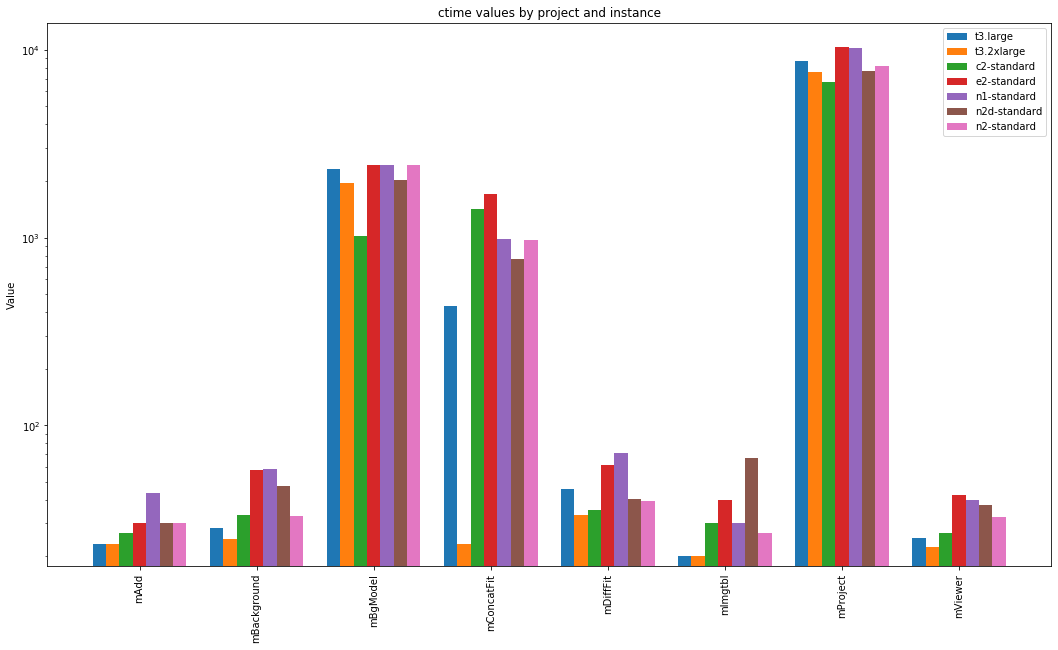

In [24]:
plt.rcParams["figure.figsize"] = (18,10)
draw_comparison_bar_plot([metrics_df_large3, metrics_df_large32, metrics_df_c2_standard, metrics_df_e2_standard, metrics_df_n1_standard, metrics_df_n2d_standard, metrics_df_n2_standard], 'ctime', ['t3.large', 't3.2xlarge', 'c2-standard', 'e2-standard', 'n1-standard', 'n2d-standard', 'n2-standard'], log=True)